# Download the dataset part

In [1]:
! curl -Lo /kaggle/bdd_00.zip http://dl.yf.io/bdd100k/video_parts/bdd100k_videos_train_00.zip
! unzip -qq /kaggle/bdd_00.zip -d /kaggle
! rm /kaggle/bdd_00.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.4G  100 18.4G    0     0  7871k      0  0:40:56  0:40:56 --:--:-- 8227k


# Download the trajectories

In [2]:
!pip install gdown
!gdown --id --no-cookies 1IfX0dHDn2dfhljIClfK3vGyJWp56pZJz


import pickle

with open('trajectories_with_timestamps.pkl', 'rb') as f:
    trajectories_with_timestamps = pickle.load(f)

  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - \ | done
  Preparing metadata (pyproject.toml) ... - \ | done
  Created wheel for gdown: filename=gdown-4.3.1-py3-none-any.whl size=14493 sha256=12127a4cd1ba635f95fe193ca7fece8e6d65a47e5ee59cdcb83b5ec0d52bee2c
  Stored in directory: /root/.cache/pip/wheels/39/13/56/88209f07bace2c1af0614ee3326de4a00aad74afb0f4be921d
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1IfX0dHDn2dfhljIClfK3vGyJWp56pZJz
To: /kaggle/working/trajectories_with_timestamps.pkl
100%|███████████████████████████████████████| 28.7M/28.7M [00:00<00:00, 279MB/s]


# Path setup

In [3]:
from os import listdir
from os.path import join, isfile


root_path = '/kaggle/bdd100k/videos'
save_path = '/kaggle/working'
videos_path = f'{root_path}/train'
frames_path = f'{save_path}/frames'

videos_names =[f for f in listdir(videos_path) if isfile(join(videos_path, f))]

# Process videos

## Reset output directory

In [4]:
def reset_output_dir():
    !rm -rf $frames_path && mkdir $frames_path
    return

reset_output_dir()

## Processing

In [5]:
import subprocess
from multiprocessing import Pool
from os import devnull, mkdir, rmdir
from functools import partial

import warnings

def extract_frames(frames_path, videos_path, video_name):
    name = video_name[:-4]
    output_path = f'{frames_path}/{name}'
    mkdir(output_path)
    info_file_name = f'{name}.json' 
    try:
        timestamps = trajectories_with_timestamps[info_file_name]
    except:
        # This means the video isn't in our processing limits `50 <= displacement <= 2500`.
#         warning.warn(f"Couldn't find the timestamps for {name}")
        rmdir(output_path)
        return

  
    with open(devnull, 'w') as f:
        for idx, timestamp in enumerate(timestamps):
            subprocess.call(['ffmpeg',
                             '-hide_banner',
                             '-loglevel',
                             'error',
                             '-ss',
                             timestamp,
                             '-i',
                             f'{videos_path}/{video_name}',
                             '-frames:v',
                             '1',
                             '-q:v',
                             '2',
                             '-vf',
                             'scale=400:-1:flags=lanczos',
                             f'{output_path}/{idx:02d}.png'
                            ], stdout=f)
            
def process_all_videos():
    pool = Pool(processes=4)
    pool.map(partial(extract_frames, frames_path, videos_path), videos_names)

In [6]:
process_all_videos()

# Visualize output

In [7]:
from random import choice
from os import listdir

from IPython.display import Image, FileLink


def make_gif_from_frames(frames_path, output_path, *,loop=-1, fps=10):
    subprocess.check_call(['ffmpeg',
                           '-y',
                           '-hide_banner',
                           '-loglevel',
                           'error',
                           '-f',
                           'image2',
                           '-framerate',
                           str(fps),
                           '-pattern_type',
                           'glob',
                           '-i',
                           f"{frames_path}/*.png",
                           '-loop',
                           str(loop),
                           output_path
                        ])
    return Image(open(output_path, 'rb').read())    

def get_random_processed_video_name():
    return choice(listdir(frames_path))

In [8]:
name = get_random_processed_video_name()

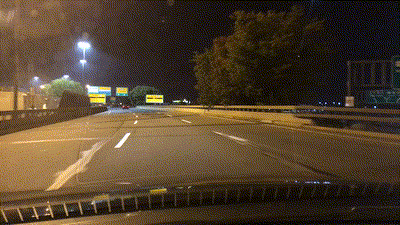

In [9]:
output_path = f'{name}.gif'
make_gif_from_frames(f'{frames_path}/{name}',output_path, loop=1, fps=5)


In [10]:
FileLink(f'{name}.gif')

/kaggle/working/00e100a8-a5e1ece9.gif

In [11]:
! ls /kaggle/working/frames | wc -l

709
